In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CONTEXT: 
Company X intends to build a face identification model to recognise human faces.

# DATA DESCRIPTION: 
The dataset comprises of images and its mask where there is a human face.

# PROJECT OBJECTIVE: 
Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken 
from 'Pinterest' and aligned using dlib library. Some data samples:

In [2]:
import os
os.chdir('/content/drive/My Drive/PyData/CVProject2')

Extarcting zip file

In [ ]:
images_zip_path = 'PINS.zip'
from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

Importing all the relevant libraries

In [3]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2022

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.3.5
Numpy version: 1.21.6
Scikit-learn version: 1.0.2
Tensorflow version: 2.9.2
CV version: 4.6.0


Function to extract meta data

In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])


Function to load image

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

Loading image using the function

In [ ]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

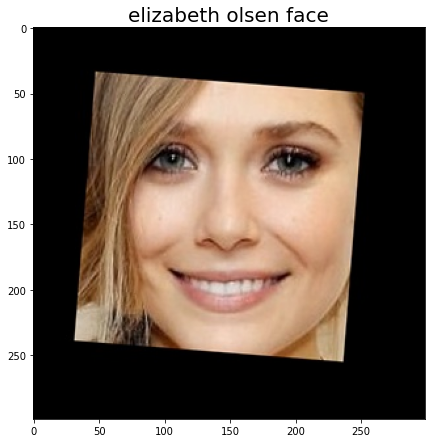

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

VGG face model

In [ ]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

Loading the model and load the given weights file named 'vgg_face_weights.h5'

In [ ]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

Get vgg_face_descriptor

In [ ]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

Generate embeddings for each image in the dataset

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 6s 6s/step
(2622,)


Generate embeddings for all images

In [ ]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 18ms/step


Function to calculate distance between given 2 pairs of images.

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

Plot images and get distance between the pairs.

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))


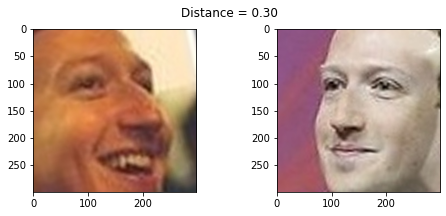

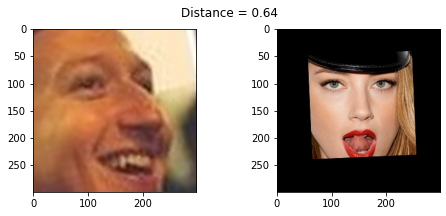

In [ ]:
show_pair(2, 3)
show_pair(2, 180)


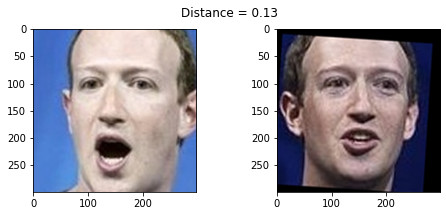

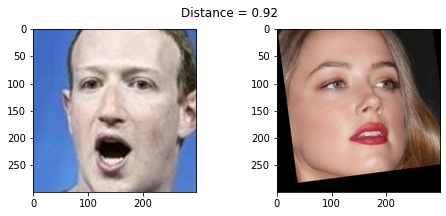

In [ ]:
show_pair(30, 31)
show_pair(30, 100)

Create train and test sets



In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [ ]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)


In [ ]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

Reduce dimensions using PCA

In [ ]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.56419266  18.95816858  22.93291641 ...  99.99999983  99.99999999
 100.        ]


In [ ]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')


Index of element just greater than 95: 347


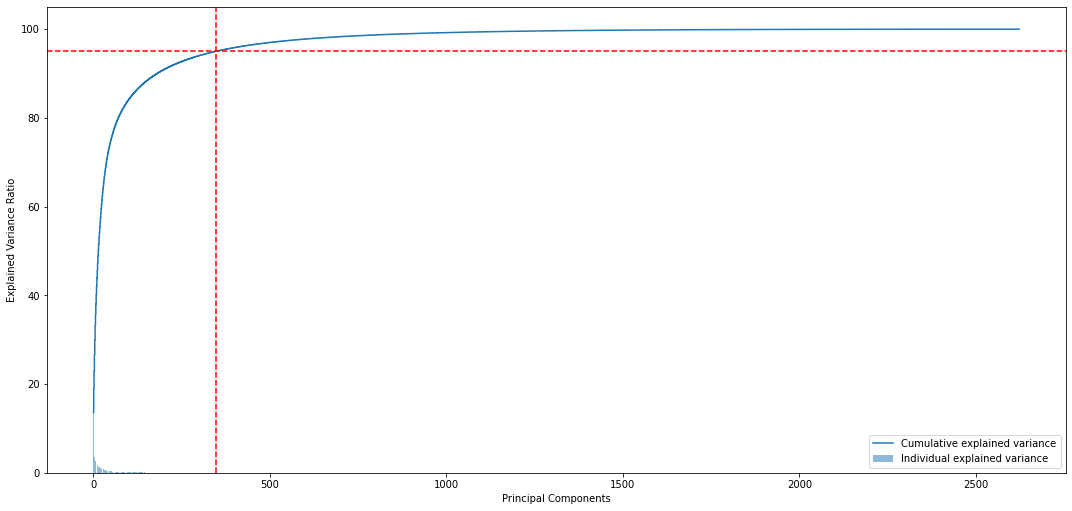

In [ ]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()


In [ ]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 347)

(1197, 347)

GridsearchCV for finding out best hyperparameters of SVM 

In [ ]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': ['balanced', None]}]

svc = GridSearchCV(SVC(random_state = random_state), params_grid, cv = 3, scoring = 'f1_macro', verbose = 50, n_jobs = -1)
svc.fit(X_train_pca, y_train)

print('Best estimator found by grid search:')
print(svc.best_estimator_)

#Best estimator found by grid search:
SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced')


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best estimator found by grid search:
SVC(C=10, class_weight='balanced', gamma=0.001, random_state=2022)


SVC(C=1, class_weight='balanced', gamma=0.001)

In [ ]:
svc_pca = SVC(C = 10, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 1.000


In [ ]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.965


In [ ]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       1.00      1.00      1.00        10
            Alvaro Morte       1.00      0.93      0.96        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         8
          Amaury Nolasco       1.00      1.00      1.00         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       0.93      0.93      0.93        14
           Anne Hathaway       1.00      0.92      0.96        13
     Barbara Palvin Face       1.00      0.89      0.94         9
      Bellamy Blake Face       0.92      0.92      0.92        13
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.83      1.00      

Test results

In [ ]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

1/1 [==============================] - 0s 21ms/step


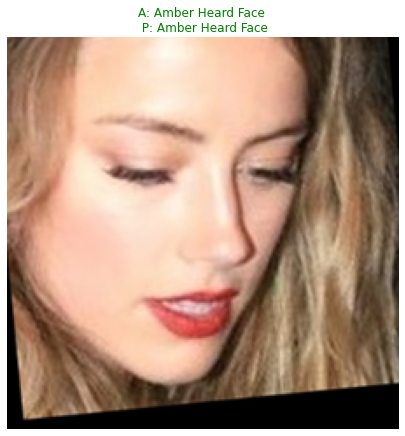

In [ ]:
# Plot for 10th image in test data
sample_img, actual_name, pred_name = sample_img_plot(10)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()


1/1 [==============================] - 0s 23ms/step


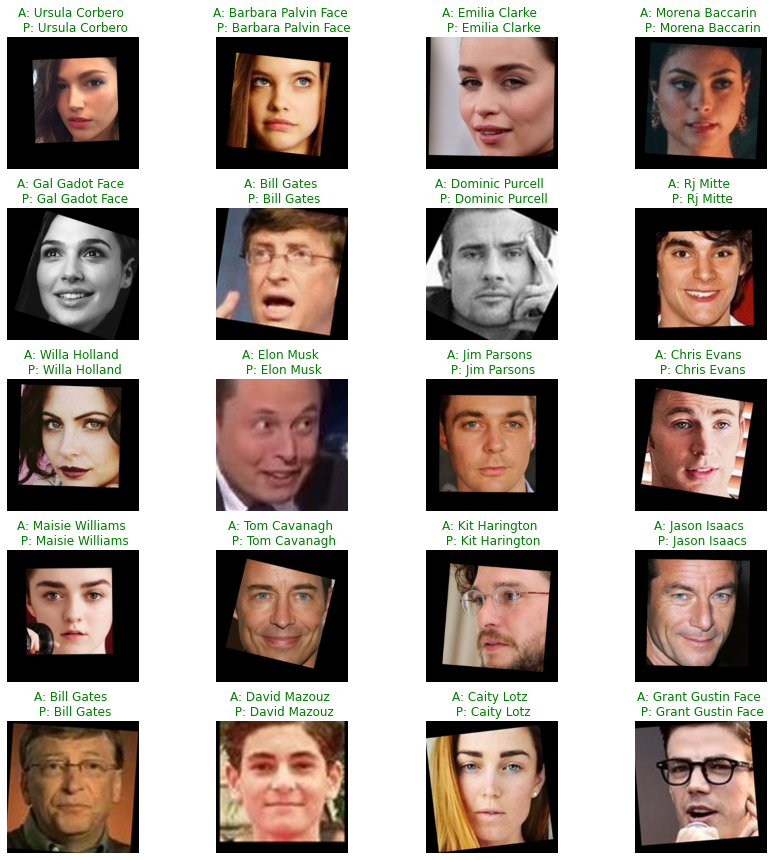

In [ ]:
# Random 20 sample images from test data
plt.figure(figsize = (15, 15))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.3) 

for i in range(20):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))
  
    plt.axis('off')
    plt.imshow(sample_img)
  
    plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

Testing the given images of Dwayne johnson and benedict cumberbach

Image width: 299
Image width: 299


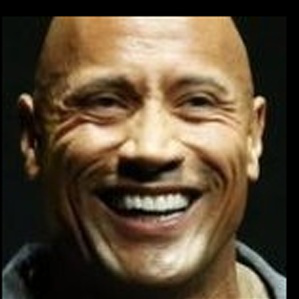

In [ ]:
# Import single images

from PIL import Image   # pip install pillow
  
Image_name1 = 'test_img/Dwayne Johnson4.jpg'
with Image.open(Image_name1) as image1: 
    width, height = image1.size 

print("Image width:",width)    

print("Image width:",height)
     
Image.open(Image_name1)

Image width: 299
Image width: 299


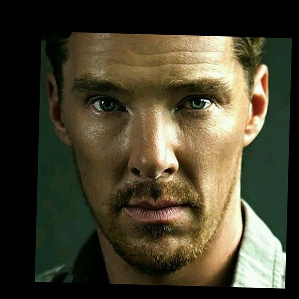

In [ ]:
Image_name2 = "test_img/Benedict Cumberbatch9.jpg"
with Image.open(Image_name2) as image2: 
    width, height = image2.size 

print("Image width:",width)    

print("Image width:",height)
    
Image.open(Image_name2)

In [ ]:
def test_img_plot(imgPath,actualname):
  # Load .jpg format image
  test_img = load_image(imgPath)
  # resize and normalize the image
  test_img = (test_img / 255.).astype(np.float32)
  test_img = cv2.resize(test_img, dsize = (224, 224))
  # actual name
  actual_name = actualname
  
  # Obtain embedding vector for test image
  embedding = vgg_face_descriptor.predict(np.expand_dims(test_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return test_img, actual_name, pred_name

1/1 [==============================] - 0s 16ms/step


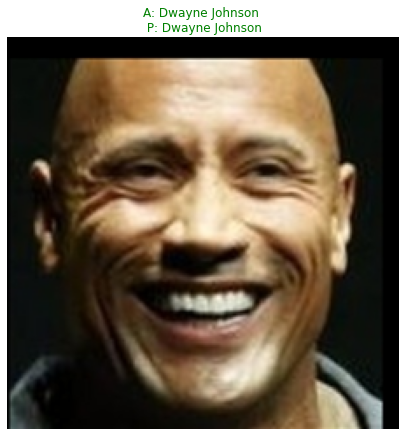

In [ ]:
test_img, actual_name, pred_name = test_img_plot(Image_name1,"Dwayne Johnson")
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(test_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()


1/1 [==============================] - 0s 16ms/step


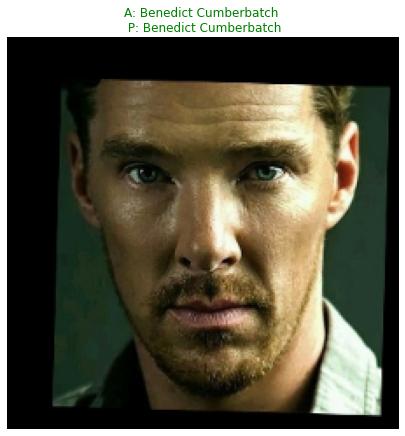

In [ ]:
test_img, actual_name, pred_name = test_img_plot(Image_name2,"Benedict Cumberbatch")
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(test_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

# CONTEXT: 
Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. 
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie 
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and 
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the

# DATA DESCRIPTION: 
The dataset comprises of images and its mask for corresponding human face.

# OBJECTIVE: 
To build a face detection system.

Importing and reading the image

In [5]:
data = np.load('images.npy', allow_pickle = True)
data.shape

(409, 2)

In [6]:
images = data[:,0]
mask = data[:,1]
print(images.shape, mask.shape)

(409,) (409,)


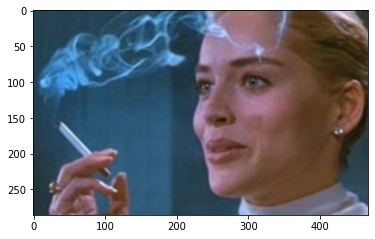

In [7]:
# Plotting few images
plt.imshow(images[120]);

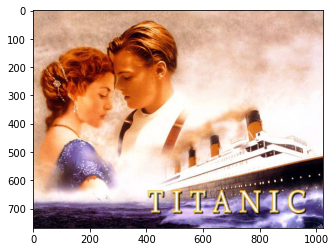

In [8]:
plt.imshow(images[382]);

In [9]:
# Shapes of different images are different
print(images[120].shape)
print(images[382].shape)

(286, 468, 3)
(768, 1024, 3)


In [ ]:
# Displaying mask of a random image
display(mask[382])

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.25826446280991733, 'y': 0.1184573002754821},
   {'x': 0.5134297520661157, 'y': 0.4834710743801653}],
  'imageWidth': 1024,
  'imageHeight': 768},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.09194214876033058, 'y': 0.16391184573002754},
   {'x': 0.3068181818181818, 'y': 0.5440771349862259}],
  'imageWidth': 1024,
  'imageHeight': 768}]

In [ ]:
#Unifying all images with 224*224 dimension
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
ALPHA = 1

In [ ]:
# Unify size
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
X.shape

(409, 224, 224, 3)

In [ ]:
#Spliting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size = 0.022, random_state = 123)

In [ ]:
#Shapes of different parts
print(X_train.shape)
print(X_test.shape)

(400, 224, 224, 3)
(9, 224, 224, 3)


[[[ 0.52156866  0.41176474  0.10588241]
  [ 0.50588238  0.39607847  0.09019613]
  [ 0.51372552  0.4039216   0.09803927]
  ...
  [ 0.10588241 -0.01960784 -0.21568626]
  [ 0.11372554 -0.01176471 -0.19999999]
  [ 0.10588241 -0.01960784 -0.19999999]]

 [[ 0.52156866  0.41176474  0.10588241]
  [ 0.51372552  0.4039216   0.09803927]
  [ 0.51372552  0.4039216   0.09803927]
  ...
  [ 0.09803927 -0.02745098 -0.2235294 ]
  [ 0.10588241 -0.01960784 -0.21568626]
  [ 0.09019613 -0.03529412 -0.20784312]]

 [[ 0.52941179  0.41960788  0.11372554]
  [ 0.52941179  0.41960788  0.11372554]
  [ 0.52941179  0.41960788  0.11372554]
  ...
  [ 0.09019613 -0.03529412 -0.23137254]
  [ 0.09019613 -0.03529412 -0.23137254]
  [ 0.082353   -0.04313725 -0.23921567]]

 ...

 [[-0.01176471  0.3176471   0.37254906]
  [ 0.02745104  0.30980396  0.34901965]
  [ 0.01176476  0.24705887  0.27058828]
  ...
  [-0.86666667 -0.85882354 -0.88235295]
  [-0.93725491 -0.81960785 -0.80392158]
  [-0.02745098  0.06666672  0.082353  ]]

 [

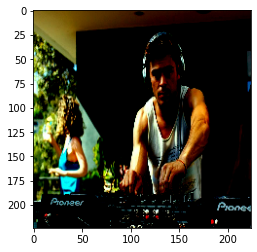

In [ ]:
# After choosing a random train and test image displaying the image and it's mask
from matplotlib import pyplot
n = 20
print(X_train[n])
pyplot.imshow(X_train[n])

[[[-0.16862744 -0.12941176 -0.30196077]
  [-0.09019607 -0.06666666 -0.23137254]
  [ 0.00392163  0.0196079  -0.14509803]
  ...
  [-0.86666667 -0.78039217 -0.89019608]
  [-0.85882354 -0.79607844 -0.89803922]
  [-0.8509804  -0.79607844 -0.89803922]]

 [[-0.17647058 -0.14509803 -0.31764704]
  [-0.09803921 -0.0745098  -0.23921567]
  [-0.01176471  0.00392163 -0.1607843 ]
  ...
  [-0.85882354 -0.79607844 -0.89803922]
  [-0.8509804  -0.78823531 -0.89019608]
  [-0.84313726 -0.78039217 -0.88235295]]

 [[-0.19999999 -0.1607843  -0.34117645]
  [-0.11372548 -0.09019607 -0.25490195]
  [-0.03529412 -0.01960784 -0.18431371]
  ...
  [-0.85882354 -0.81176472 -0.90588236]
  [-0.84313726 -0.78039217 -0.88235295]
  [-0.85882354 -0.77254903 -0.88235295]]

 ...

 [[-0.28627449 -0.20784312 -0.19999999]
  [-0.54509807 -0.46666664 -0.4588235 ]
  [-0.50588238 -0.42745095 -0.41960782]
  ...
  [-0.09803921 -0.24705881 -0.38039213]
  [-0.11372548 -0.24705881 -0.38823527]
  [-0.13725489 -0.27058822 -0.41176468]]

 [

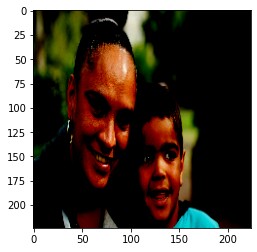

In [ ]:
from matplotlib import pyplot
n1 = 3
print(X_test[n1])
pyplot.imshow(X_test[n1])

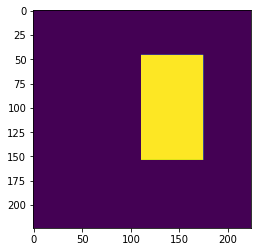

In [ ]:
pyplot.imshow(masks[n])

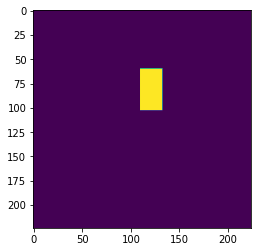

In [ ]:
pyplot.imshow(masks[n1])

In [ ]:
# Model design
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

HEIGHT_CELLS = 28
WIDTH_CELLS = 28
BATCH_SIZE = 1

In [ ]:
model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock) 

In [ ]:
model = create_model()
# Print summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [ ]:
# Dice coefficient
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
# Loss funtion
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [ ]:
model = create_model(False)
model.summary()
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer = optimizer, metrics=[dice_coefficient])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=1, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
model.fit(X_train,y_train,epochs = 10,verbose=1,batch_size=8,callbacks=[checkpoint,reduce_lr, stop])

Epoch 1/10

Epoch 1: loss improved from inf to 2.58618, saving model to model-2.59.h5
 1/50 [..............................] - ETA: 3:06 - loss: 2.5862 - dice_coefficient: 0.1751
Epoch 1: loss improved from 2.58618 to 2.41081, saving model to model-2.41.h5
 2/50 [>.............................] - ETA: 19s - loss: 2.4108 - dice_coefficient: 0.2125 
Epoch 1: loss did not improve from 2.41081
 3/50 [>.............................] - ETA: 14s - loss: 2.4468 - dice_coefficient: 0.2011
Epoch 1: loss did not improve from 2.41081
 4/50 [=>............................] - ETA: 12s - loss: 2.5902 - dice_coefficient: 0.1774
Epoch 1: loss did not improve from 2.41081
 5/50 [==>...........................] - ETA: 11s - loss: 2.5902 - dice_coefficient: 0.1730
Epoch 1: loss did not improve from 2.41081
 6/50 [==>...........................] - ETA: 11s - loss: 2.4702 - dice_coefficient: 0.1945
Epoch 1: loss improved from 2.41081 to 2.37870, saving model to model-2.38.h5
 7/50 [===>.....................

In [ ]:
test_image = X_test[n1]

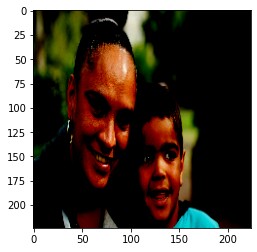

In [ ]:
plt.imshow(test_image);

1/1 [==============================] - 1s 780ms/step


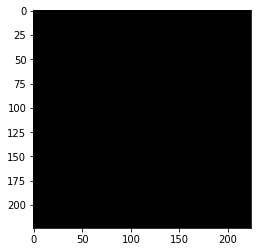

In [ ]:
sample_image = test_image
image = cv2.resize(sample_image, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.2), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image);

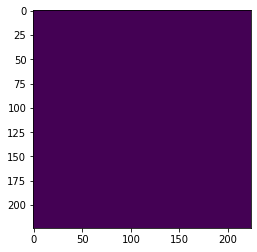

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pred_mask, alpha=1);

# CONTEXT: 
Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription 
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on 
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer 
vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in this.

# DATA DESCRIPTION: 
The dataset comprises of face images.

# OBJECTIVE: 
To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

In [ ]:
# Extarction of images from zip folder
images_zip_path = 'training_images-20211126T092819Z-001.zip'
from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [4]:
# Creating a function for loading images from the folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [5]:
imgTrain = load_images_from_folder('training_images')

In [6]:
# loading face cascading classifier 
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [7]:
# Counting number of images
len(imgTrain)

1091

Viewing and checking dimension of arbitrary images

shape of the image (600, 600, 3)


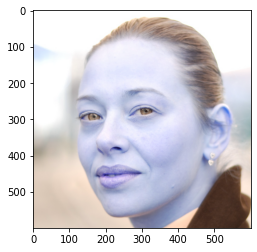

In [8]:
print("shape of the image",imgTrain[10].shape)
plt.imshow(imgTrain[10]);

shape of the image (600, 600, 3)


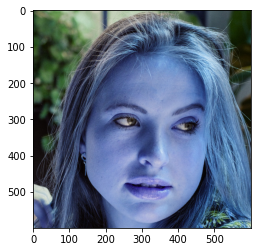

In [9]:
print("shape of the image",imgTrain[100].shape)
plt.imshow(imgTrain[100]);

shape of the image (600, 600, 3)


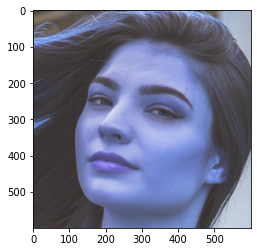

In [10]:
print("shape of the image",imgTrain[1090].shape)
plt.imshow(imgTrain[1090]);

**Function for face detection using 'haarcascade_frontalface_default.xml’**

In [11]:
from google.colab.patches import cv2_imshow

In [12]:
def detect_faces(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_coordinates = face_cascade.detectMultiScale(gray_img)
    for coordinate in face_coordinates:
        (x, y, w, h) = coordinate
        colors = np.random.randint(1, 255, 3)
        cv2.rectangle(image, (x, y), (x + w, y + h), (int(colors[0]), int(colors[1]), int(colors[2])), thickness=2)
    cv2_imshow(image)
    cv2.waitKey(0)

Detecting face for first 5 images

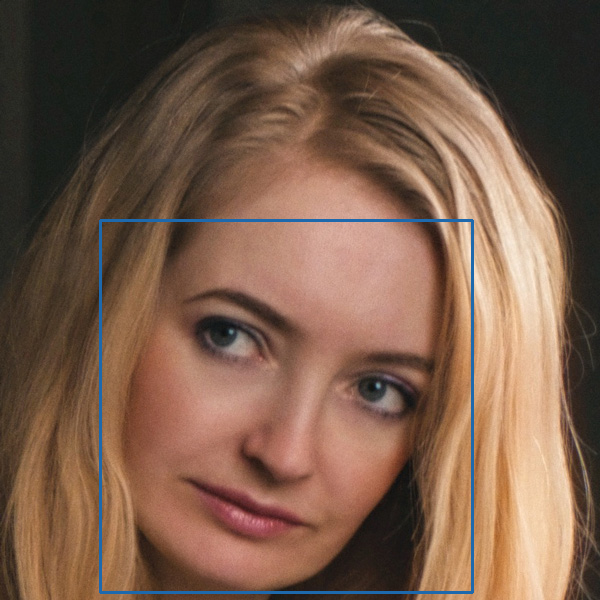

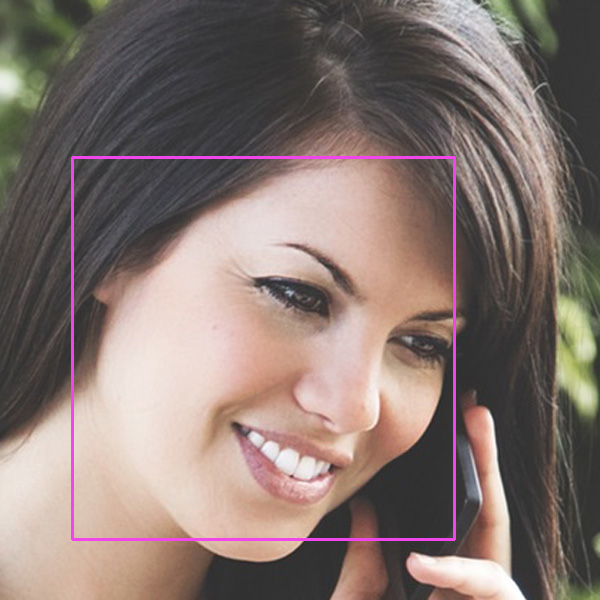

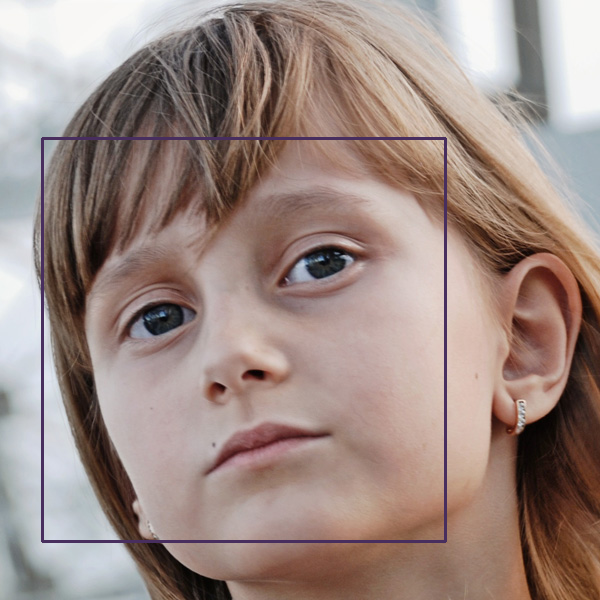

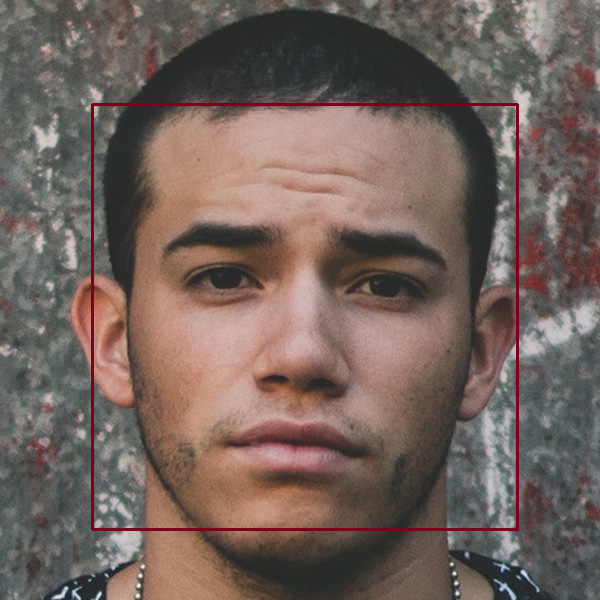

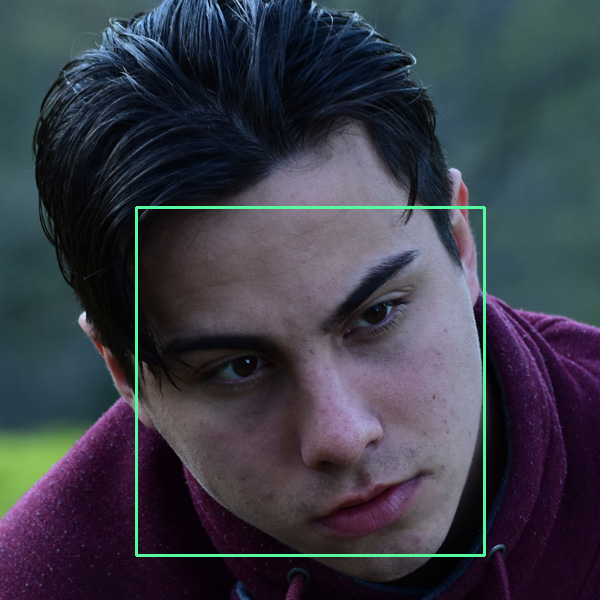

In [13]:
for i in range(5):
  detect_faces(imgTrain[i])

Detecting faces of all the images and creating data frame

In [14]:
img_file_names = os.listdir('training_images')

In [15]:
img_df = pd.DataFrame(columns = ['X','Y','W','h','Total_faces','Image_Name'])

In [16]:
undetected_imgs = []
detected_imgs = []

for imgs, fnames in tqdm(zip(imgTrain,img_file_names )):
  gray_img = cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)
  face_coordinates = face_cascade.detectMultiScale(gray_img,1.1,4)
  if len(face_coordinates) == 0:
    undetected_imgs.append(fnames)
    dict = {'X':0,'Y':0,'W':-1,'h':-1,'Total_faces': 0,'Image_Name':fnames}
  else:
    detected_imgs.append(fnames)
    for (x,y,w,h) in face_coordinates:
      dict = {'X':x,'Y':y,'W':w,'h':h,'Total_faces': len(face_coordinates),'Image_Name':fnames}
      img_df = img_df.append(dict,ignore_index = True)  

0it [00:00, ?it/s]

In [18]:
img_df

X    Y    W    h Total_faces      Image_Name
0     106  220  375  375           1  real_01035.jpg
1      41  138  405  405           1  real_01043.jpg
2      93  105  424  424           1  real_00999.jpg
3     124  156  401  401           1  real_01026.jpg
4      95  151  405  405           1  real_00979.jpg
...   ...  ...  ...  ...         ...             ...
1005   74   54  464  464           1  real_01007.jpg
1006   89  104   57   57           2  real_01013.jpg
1007  193  150  377  377           2  real_01013.jpg
1008  150  161  384  384           1  real_01030.jpg
1009   36   82  441  441           1  real_00968.jpg

[1010 rows x 6 columns]

In [19]:
# saving the data frame into a csv file
img_df.to_csv('Image_data.csv')